In [1]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit
import numpy as np
import qiskit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
print(qiskit.__version__)

2.1.1


Idea is to:
1. Prepare two qubits in ++
2. Simulate a stark shift
2. Do N XX gates
4. Do analysis pulses and look at stark shifts

In [10]:
def sim_stark_shift(n_xx_gates, common_mode_shift, diff_mode_shift):
    # Parameters
    n_steps = 100  
    rz_angles = np.linspace(0, 2*np.pi, n_steps) 

    comm = common_mode_shift
    diff = diff_mode_shift
    stark_shift_q0 = (comm - diff) * 2 * np.pi
    stark_shift_q1 = (comm + diff) * 2 * np.pi

    # Initialize arrays for populations
    qubit0_probs = np.zeros(n_steps)
    qubit1_probs = np.zeros(n_steps)

    for i, angle in enumerate(rz_angles):
        qc = QuantumCircuit(2)
        
        # Prepare State
        qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1)
        qc.rz(np.pi/2, 0)
        qc.rz(np.pi/2, 1)

        for n in range(n_xx_gates):
            # Apply XX gate
            if n % 2 == 0:
                qc.rxx(np.pi / 2, 0, 1)
            else:
                qc.rxx(-np.pi / 2, 0, 1)
            
            # Apply stark shift
            qc.rz(stark_shift_q0, 0)
            qc.rz(stark_shift_q1, 1)

        # Analysis pulses
        qc.rz(angle, 0)
        qc.rz(angle, 1)
        qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1)
        
        state = Statevector(qc)
        
        # Draw the circuit one time
        if angle == 0:
            print(qc.draw())

        # Calculate populations
        qubit0_probs[i] = state.probabilities([0])[1]
        qubit1_probs[i] = state.probabilities([1])[1]

    qubit_0_min = rz_angles[np.argmin(qubit0_probs)]
    qubit_1_min = rz_angles[np.argmin(qubit1_probs)]
    print(f"minimum of qubit 0 at:{round(qubit_0_min, 6)} rad")
    print(f"minimum of qubit 1 at:{round(qubit_1_min, 6)} rad")
    print(f"difference: {qubit_0_min - qubit_1_min}")
    plt.figure(figsize=(10, 5))
    plt.plot(rz_angles, qubit0_probs, label="Qubit 0 |1⟩ Population", color="blue")
    plt.plot(rz_angles, qubit1_probs, label="Qubit 1 |1⟩ Population", color="red", linestyle="--")
    plt.xlabel("Rz Angle (radians)")
    plt.title(f"Stark shift with {n_xx_gates} XX gate - {comm}% common mode shift {diff}% differential shift")
    plt.ylabel("Population")
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
            ['0', 'π/2', 'π', '3π/2', '2π'])
    plt.legend()
    plt.grid(True)
    plt.show()

---Trying 0 XX Gates---
     ┌─────────┐┌─────────┐┌───────┐┌─────────┐
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(0) ├┤ Rx(π/2) ├
     ├─────────┤├─────────┤├───────┤├─────────┤
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(0) ├┤ Rx(π/2) ├
     └─────────┘└─────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.586663 rad
minimum of qubit 1 at:1.586663 rad
difference: 0.0


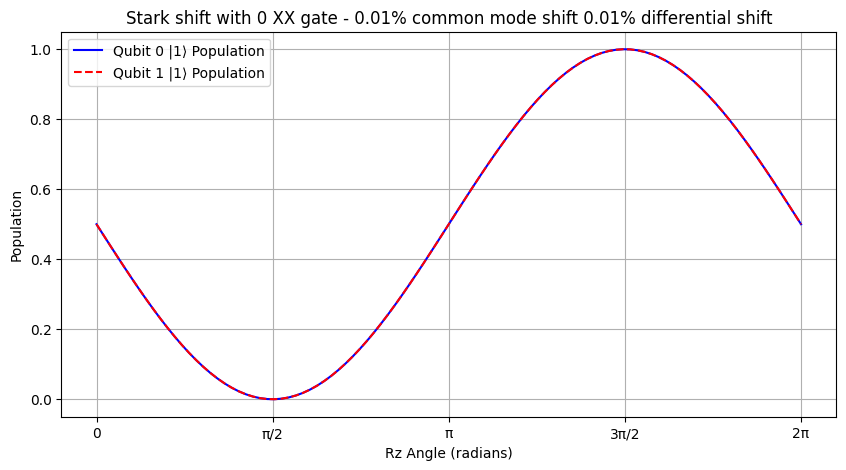

--------------
---Trying 1 XX Gates---
     ┌─────────┐┌─────────┐┌───────────┐ ┌───────┐  ┌───────┐┌─────────┐
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├─┤ Rz(0) ├──┤ Rz(0) ├┤ Rx(π/2) ├
     ├─────────┤├─────────┤│  Rxx(π/2) │┌┴───────┴─┐├───────┤├─────────┤
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(π/25) ├┤ Rz(0) ├┤ Rx(π/2) ├
     └─────────┘└─────────┘└───────────┘└──────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.586663 rad
minimum of qubit 1 at:1.45973 rad
difference: 0.1269330365086787


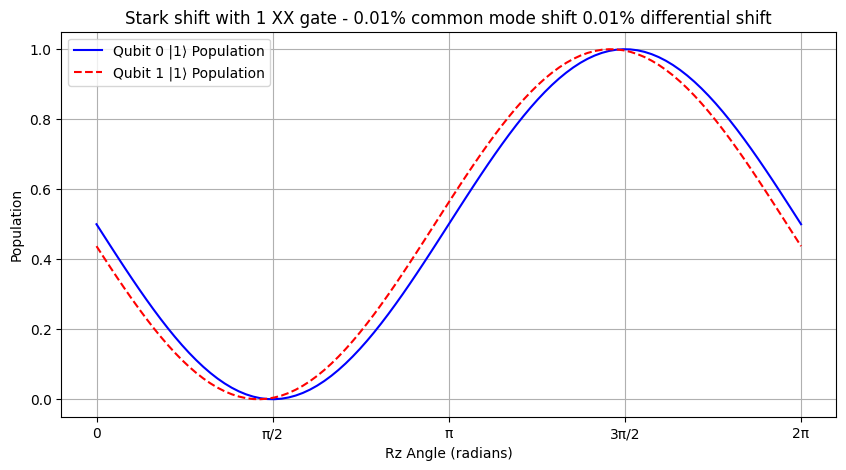

--------------
---Trying 3 XX Gates---
     ┌─────────┐┌─────────┐┌───────────┐ ┌───────┐  ┌────────────┐ ┌───────┐  »
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├─┤ Rz(0) ├──┤0           ├─┤ Rz(0) ├──»
     ├─────────┤├─────────┤│  Rxx(π/2) │┌┴───────┴─┐│  Rxx(-π/2) │┌┴───────┴─┐»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(π/25) ├┤1           ├┤ Rz(π/25) ├»
     └─────────┘└─────────┘└───────────┘└──────────┘└────────────┘└──────────┘»
«     ┌───────────┐ ┌───────┐  ┌───────┐┌─────────┐
«q_0: ┤0          ├─┤ Rz(0) ├──┤ Rz(0) ├┤ Rx(π/2) ├
«     │  Rxx(π/2) │┌┴───────┴─┐├───────┤├─────────┤
«q_1: ┤1          ├┤ Rz(π/25) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     └───────────┘└──────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.586663 rad
minimum of qubit 1 at:1.332797 rad
difference: 0.2538660730173572


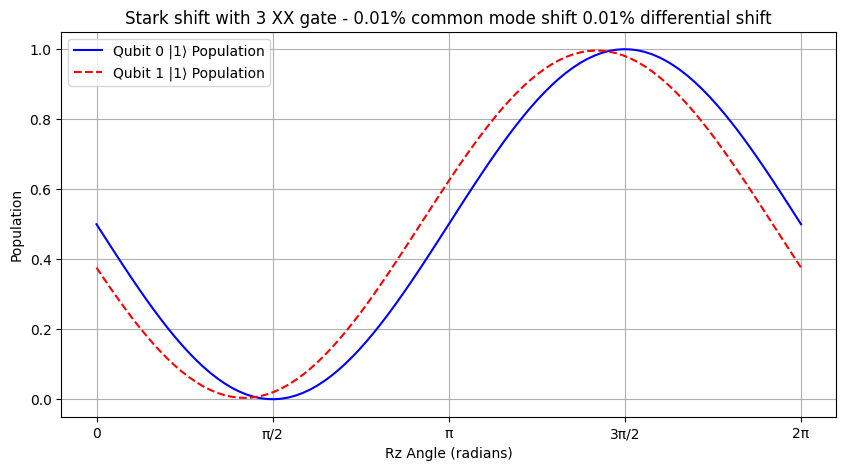

--------------
---Trying 5 XX Gates---
     ┌─────────┐┌─────────┐┌───────────┐ ┌───────┐  ┌────────────┐ ┌───────┐  »
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├─┤ Rz(0) ├──┤0           ├─┤ Rz(0) ├──»
     ├─────────┤├─────────┤│  Rxx(π/2) │┌┴───────┴─┐│  Rxx(-π/2) │┌┴───────┴─┐»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(π/25) ├┤1           ├┤ Rz(π/25) ├»
     └─────────┘└─────────┘└───────────┘└──────────┘└────────────┘└──────────┘»
«     ┌───────────┐ ┌───────┐  ┌────────────┐ ┌───────┐  ┌───────────┐»
«q_0: ┤0          ├─┤ Rz(0) ├──┤0           ├─┤ Rz(0) ├──┤0          ├»
«     │  Rxx(π/2) │┌┴───────┴─┐│  Rxx(-π/2) │┌┴───────┴─┐│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(π/25) ├┤1           ├┤ Rz(π/25) ├┤1          ├»
«     └───────────┘└──────────┘└────────────┘└──────────┘└───────────┘»
«      ┌───────┐  ┌───────┐┌─────────┐
«q_0: ─┤ Rz(0) ├──┤ Rz(0) ├┤ Rx(π/2) ├
«     ┌┴───────┴─┐├───────┤├─────────┤
«q_1: ┤ Rz(π/25) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     └──────────┘└───────┘└─────────┘
minimu

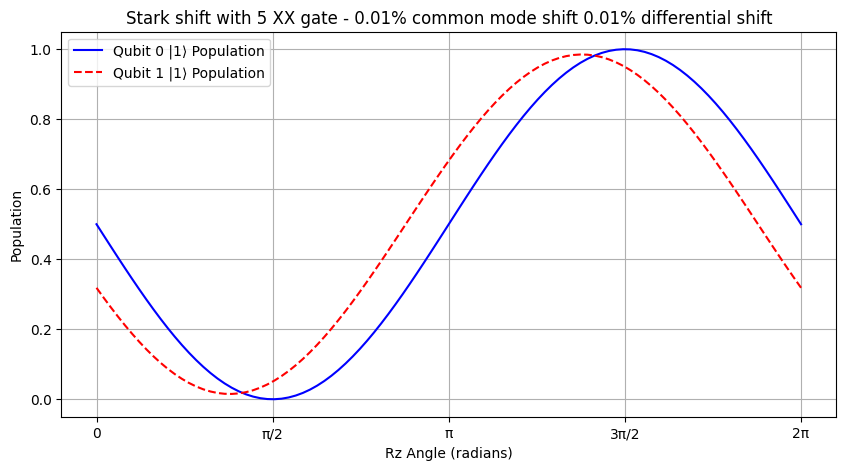

--------------
---Trying 7 XX Gates---
     ┌─────────┐┌─────────┐┌───────────┐ ┌───────┐  ┌────────────┐ ┌───────┐  »
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├─┤ Rz(0) ├──┤0           ├─┤ Rz(0) ├──»
     ├─────────┤├─────────┤│  Rxx(π/2) │┌┴───────┴─┐│  Rxx(-π/2) │┌┴───────┴─┐»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(π/25) ├┤1           ├┤ Rz(π/25) ├»
     └─────────┘└─────────┘└───────────┘└──────────┘└────────────┘└──────────┘»
«     ┌───────────┐ ┌───────┐  ┌────────────┐ ┌───────┐  ┌───────────┐»
«q_0: ┤0          ├─┤ Rz(0) ├──┤0           ├─┤ Rz(0) ├──┤0          ├»
«     │  Rxx(π/2) │┌┴───────┴─┐│  Rxx(-π/2) │┌┴───────┴─┐│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(π/25) ├┤1           ├┤ Rz(π/25) ├┤1          ├»
«     └───────────┘└──────────┘└────────────┘└──────────┘└───────────┘»
«      ┌───────┐  ┌────────────┐ ┌───────┐  ┌───────────┐ ┌───────┐  ┌───────┐»
«q_0: ─┤ Rz(0) ├──┤0           ├─┤ Rz(0) ├──┤0          ├─┤ Rz(0) ├──┤ Rz(0) ├»
«     ┌┴───────┴─┐│  Rxx(-π/2) │┌┴───────

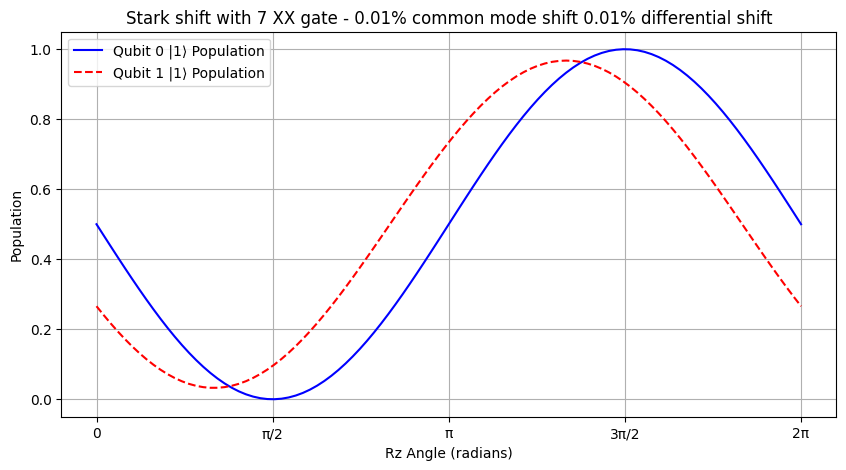

--------------


In [ ]:
comm = 0.01
diff = 0.02
for i in [0, 1, 3, 5, 7]:
    print(f"---Trying {i} XX Gates---")
    sim_stark_shift(i, comm, diff)
    print("--------------")

     ┌─────────┐┌─────────┐┌───────┐┌─────────┐
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(0) ├┤ Rx(π/2) ├
     ├─────────┤├─────────┤├───────┤├─────────┤
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(0) ├┤ Rx(π/2) ├
     └─────────┘└─────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.586663 rad
minimum of qubit 1 at:1.586663 rad
difference: 0.0


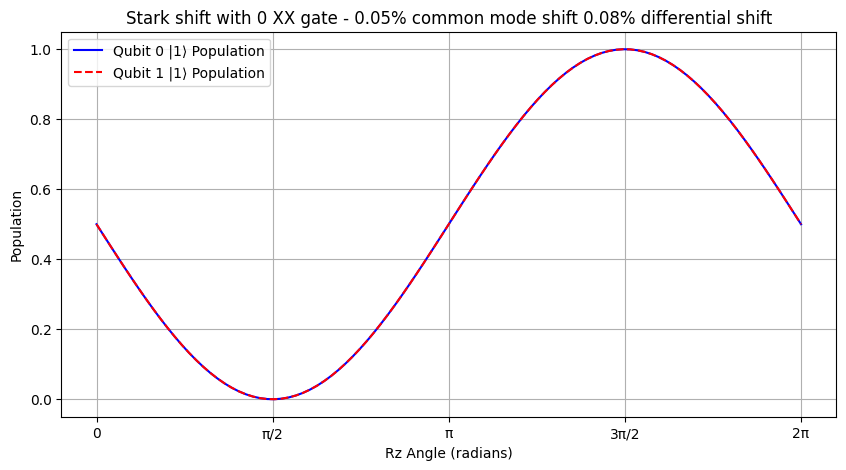

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────┐┌─────────┐
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤ Rz(0) ├┤ Rx(π/2) ├
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤├───────┤├─────────┤
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤ Rz(0) ├┤ Rx(π/2) ├
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.777063 rad
minimum of qubit 1 at:0.761598 rad
difference: 1.0154642920694281


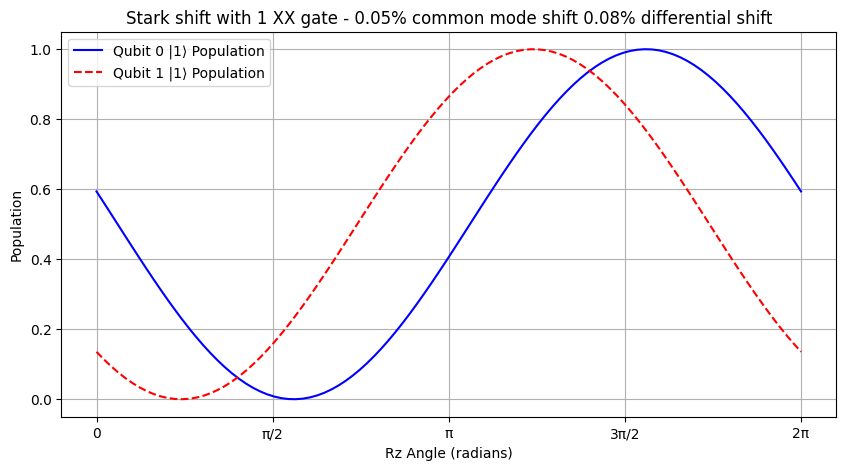

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────┐┌─────────┐
«q_0: ┤ Rz(-0.1885) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     ├─────────────┤├───────┤├─────────┤
«q_1: ┤ Rz(0.81681) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     └─────────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.777063 rad
minimum of qubit 1 at:0.761598 rad
difference: 1.0154642920694281


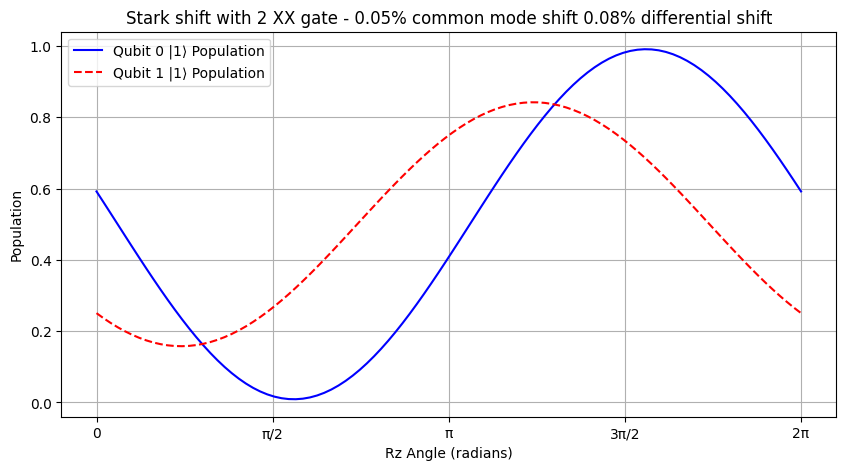

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────┐┌─────────┐
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤├───────┤├─────────┤
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     └─────────────┘└───────────┘└─────────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.650129 rad
minimum of qubit 1 at:1.713596 rad
difference: -0.06346651825433924


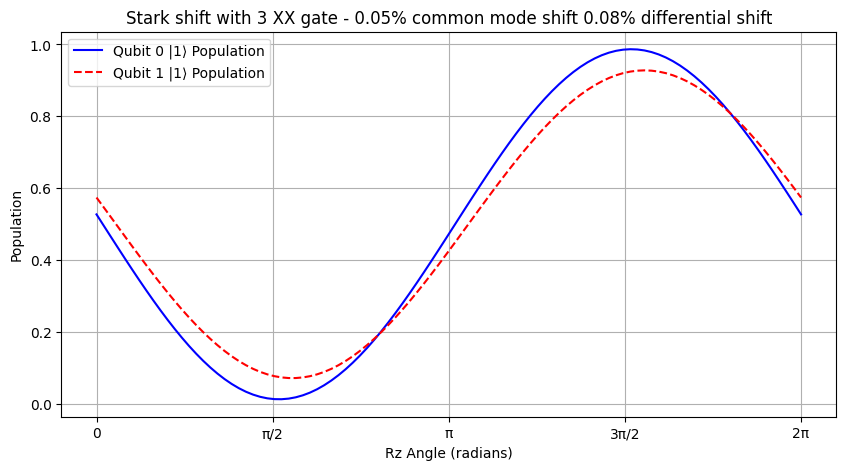

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────┐┌─────────┐
«q_0: ┤ Rz(0) ├┤ Rx(π/2) ├
«     ├───────┤├─────────┤
«q_1: ┤ Rz(0) ├┤ Rx(π/2) ├
«     └───────┘└─────────┘
minimum of qubit 0 at:1.713596 rad
minimum of qubit 1 at:1.26933 rad
difference: 0.4442656277803749


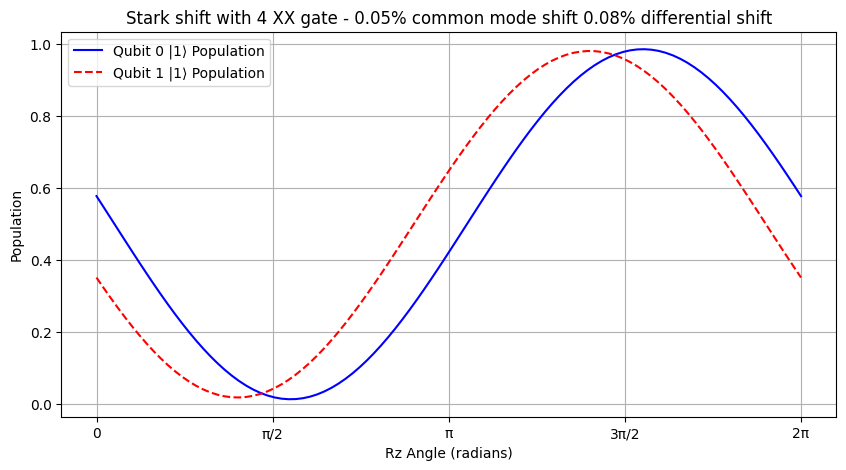

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────┐┌─────────┐
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     │  Rxx(π/2) │├─────────────┤├───────┤├─────────┤
«q_1: ┤1          ├┤ Rz(0.81681) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     └───────────┘└─────────────┘└

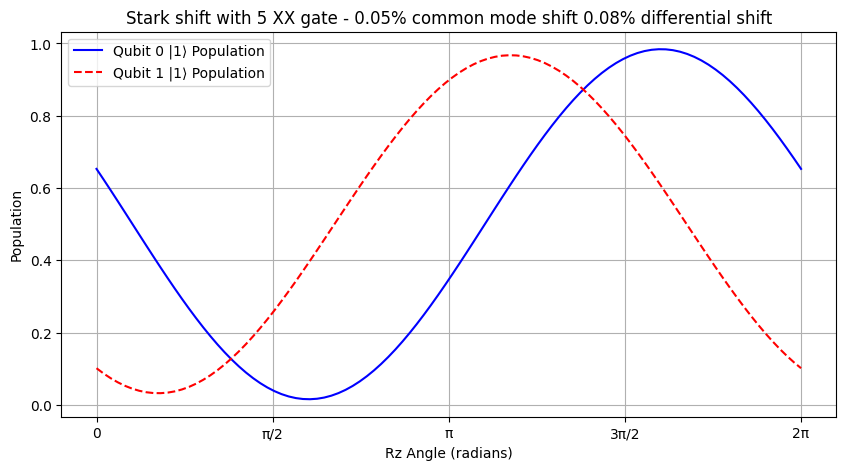

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐┌───────┐»
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤ Rz(0) ├»
«     │  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤├───────┤»
«q_1: ┤1          ├┤ Rz(0.81681) ├┤1

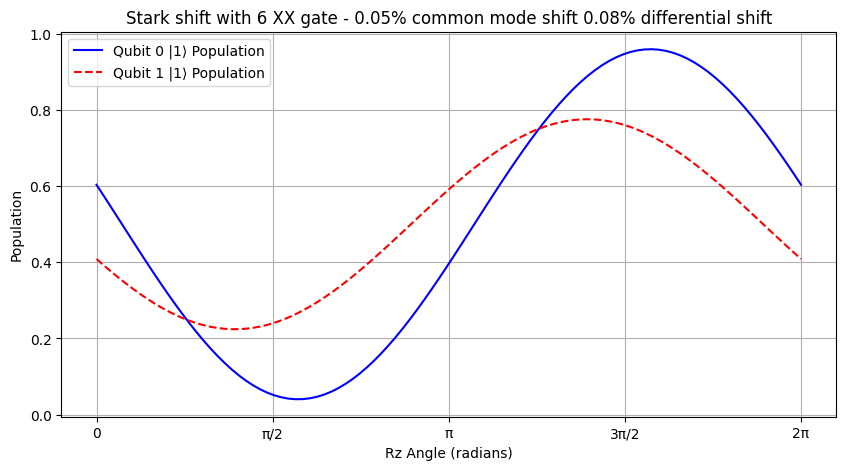

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐»
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
«     │  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(

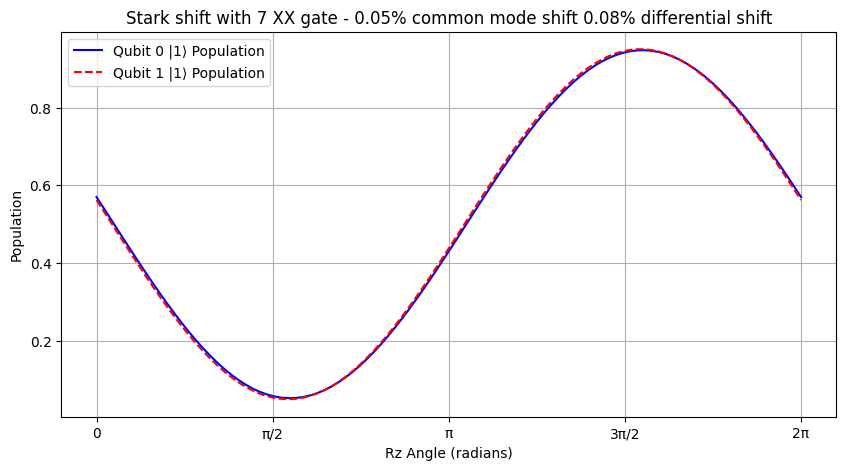

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐»
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
«     │  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(

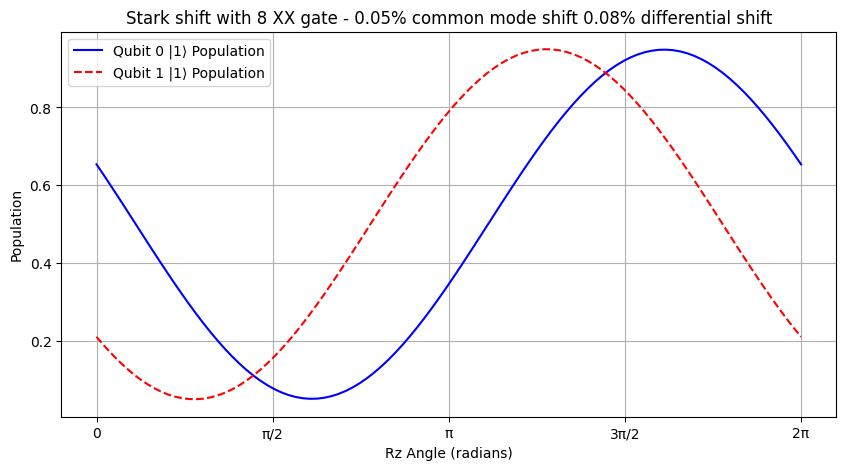

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐»
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
«     │  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(

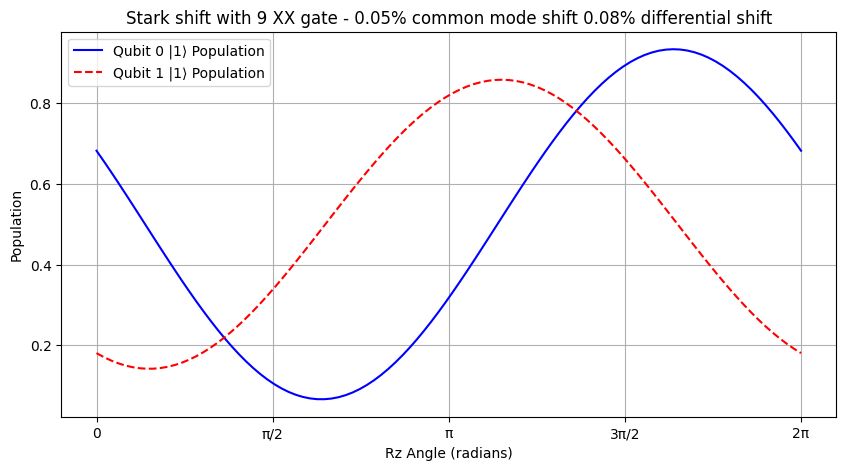

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐»
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
«     │  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(

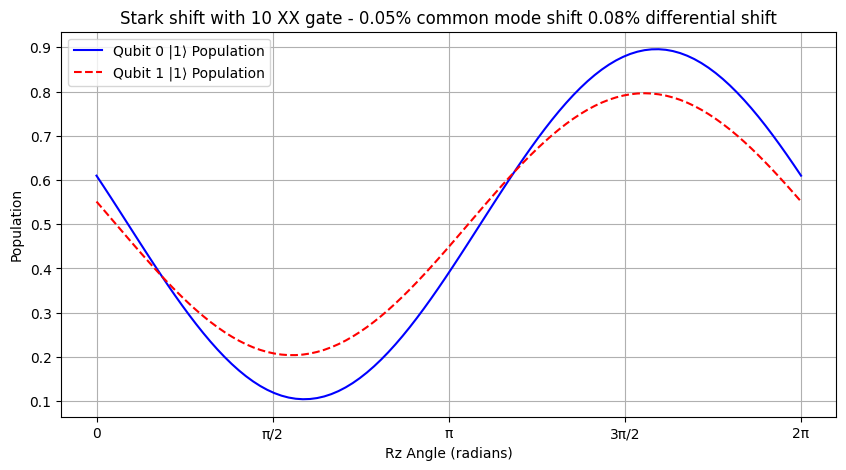

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐»
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
«     │  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(

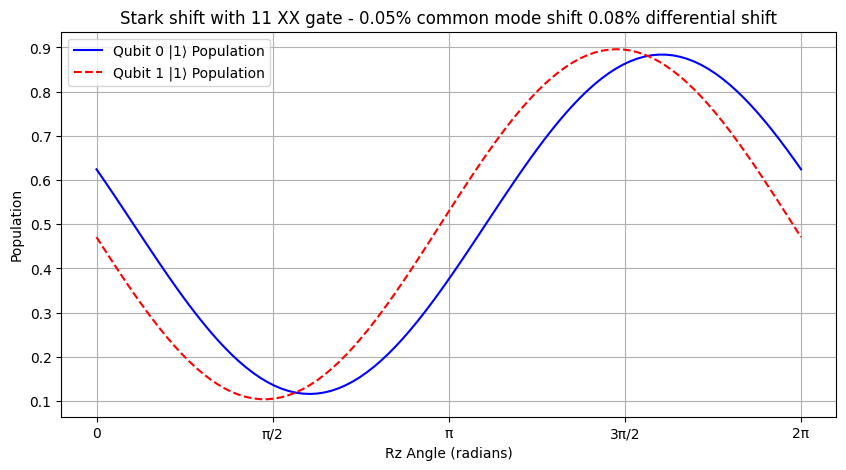

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐»
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
«     │  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(

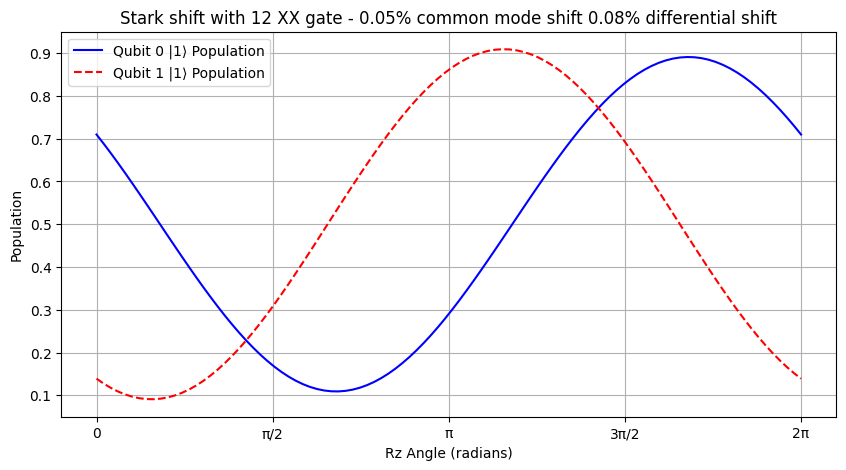

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐»
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
«     │  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(

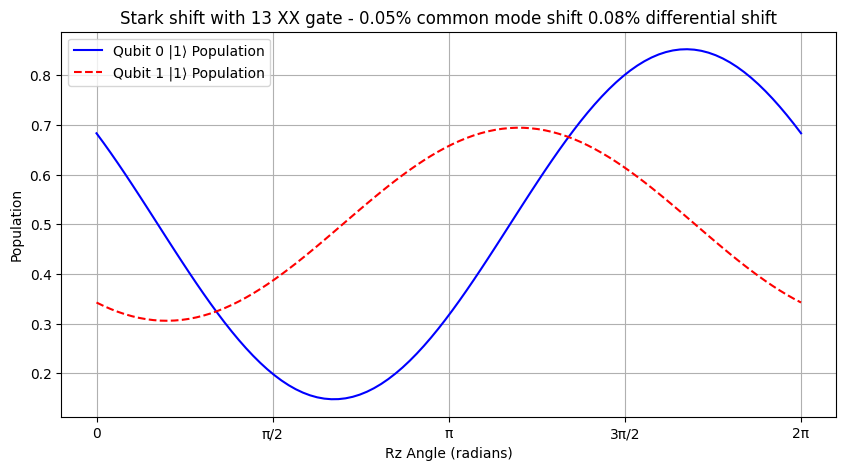

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐»
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
«     │  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(

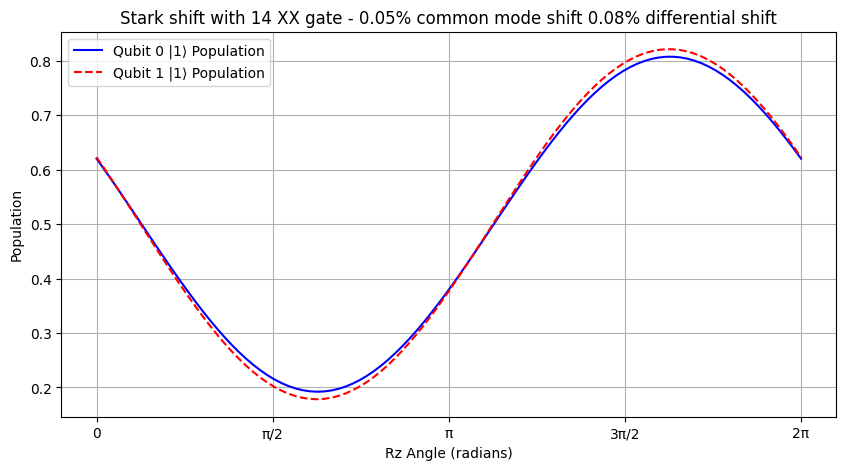

     ┌─────────┐┌─────────┐┌───────────┐┌─────────────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.81681) ├┤1          ├»
     └─────────┘└─────────┘└───────────┘└─────────────┘└───────────┘»
«     ┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐»
«q_0: ┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├»
«     ├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤»
«q_1: ┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├┤1          ├┤ Rz(0.81681) ├»
«     └─────────────┘└───────────┘└─────────────┘└───────────┘└─────────────┘»
«     ┌───────────┐┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐»
«q_0: ┤0          ├┤ Rz(-0.1885) ├┤0          ├┤ Rz(-0.1885) ├┤0          ├»
«     │  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │├─────────────┤│  Rxx(π/2) │»
«q_1: ┤1          ├┤ Rz(

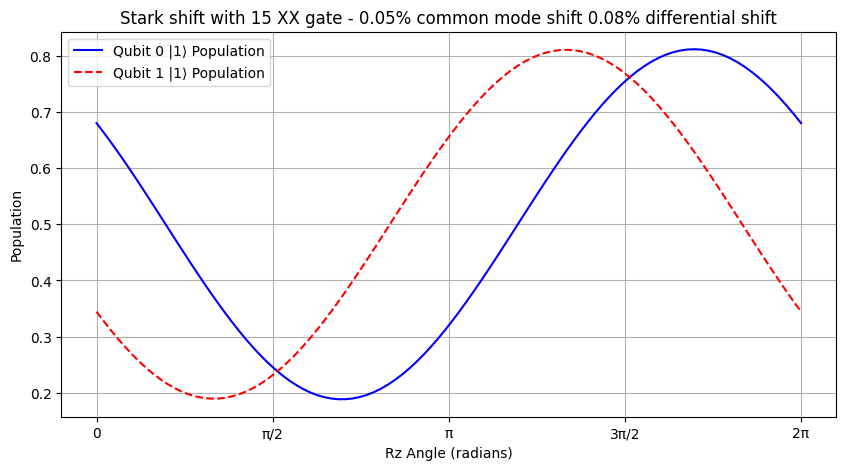

In [ ]:
for i in range(25):
    print(f"---Trying {i} XX Gates---")
    sim_stark_shift(i, comm, diff)
    print("--------------")